In [9]:
from parsing.parse_functions import parse_pdb_files
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from shape_analysis import circular_mean
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
input_pdb_dir = "/Users/kaisardauletbek/Documents/GitHub/RNA-Classification/data/rna2020_pruned_pdbs/"
suites = parse_pdb_files(input_pdb_dir, input_pdb_folder=input_pdb_dir)

In [3]:
suites[0].low_resolution_coordinates()

[4.777698713816097,
 5.237173092423049,
 65.62388562608349,
 72.88010355176152,
 20.056338853094566,
 100.71839359733033,
 -0.0020217340379483136]

In [4]:
# ---------------------------------------------------------------------------
# helpers
# ---------------------------------------------------------------------------
def spherical_to_vec(theta_deg: np.ndarray, phi_deg: np.ndarray) -> np.ndarray:
    t, p = np.radians(theta_deg), np.radians(phi_deg)
    return np.column_stack([np.sin(t) * np.cos(p),
                            np.sin(t) * np.sin(p),
                            np.cos(t)])

def arc_distance(a: np.ndarray, b: float) -> np.ndarray:
    """Shortest signed arc distance between vectors of angles a and scalar b (radians)."""
    d = (a - b + np.pi) % (2 * np.pi) - np.pi
    return d

# ---------------------------------------------------------------------------
# main routine
# ---------------------------------------------------------------------------
def scale_low_res_coords(
    suites: Sequence,
    *,
    # NEW flags:
    scale_distance_variance: bool = True,
    scale_alpha_variance:    bool = True,
    preserve_distance_mean:  bool = True,
    preserve_alpha_mean:     bool = True,
    store_attr: str = "scaled_low_res_coords"
) -> Tuple[np.ndarray, float, float]:
    """Return scaled coords plus the two scale‐factors (lambda_d, lambda_alpha)."""

    # pull raw coords
    coords = np.array([s.low_resolution_coordinates() for s in suites])
    d2, d3, alpha_deg = coords[:,0], coords[:,1], coords[:,2]
    theta1, phi1     = coords[:,3], coords[:,4]
    theta2, phi2     = coords[:,5], coords[:,6]

    # 1) compute Frechét variances
    # 1a) Euclidean on (d2,d3)
    dist_mat  = np.column_stack([d2,d3])
    mean_dist = dist_mat.mean(axis=0)
    var_d     = np.mean(np.sum((dist_mat - mean_dist)**2, axis=1))

    # 1b) intrinsic on alpha
    alpha_rad      = np.radians(alpha_deg) % (2*np.pi)
    alpha_mu_mod, var_a = circular_mean(alpha_rad)
    alpha_mu      = (alpha_mu_mod + np.pi) % (2*np.pi) - np.pi

    # 1c) spherical atoms
    vec1 = spherical_to_vec(theta1, phi1)
    vec2 = spherical_to_vec(theta2, phi2)
    var_b1 = np.mean(np.sum((vec1 - vec1.mean(axis=0))**2, axis=1))
    var_b2 = np.mean(np.sum((vec2 - vec2.mean(axis=0))**2, axis=1))

    # 2) the “target” variances from your supervisor’s formula
    v_d_target = (var_b1 + var_b2)/3
    v_a_target = (var_b1 + var_b2)/6

    # 3) raw scale‐factors
    lambda_d     = np.sqrt(v_d_target / var_d)
    lambda_alpha = np.sqrt(v_a_target / var_a)

    # 4) if user turned variance‐scaling off, reset these to 1
    if not scale_distance_variance:
        lambda_d = 1.0
    if not scale_alpha_variance:
        lambda_alpha = 1.0

    # 5) apply scaling (+ optional “preserve mean” shifts)
    if preserve_distance_mean:
        new_dist = mean_dist + lambda_d*(dist_mat - mean_dist)
    else:
        new_dist = lambda_d*dist_mat
    d2_s, d3_s = new_dist[:,0], new_dist[:,1]

    if preserve_alpha_mean:
        a_shifted = alpha_mu + lambda_alpha*arc_distance(alpha_rad, alpha_mu)
        a_shifted = (a_shifted + np.pi) % (2*np.pi) - np.pi
        alpha_s = np.degrees(a_shifted)
    else:
        alpha_s = lambda_alpha*alpha_deg

    # 6) package & store
    scaled = np.column_stack([
        d2_s, d3_s, alpha_s,
        theta1, phi1, theta2, phi2
    ])
    for suite,row in zip(suites, scaled):
        setattr(suite, store_attr, row.tolist())

    return scaled, lambda_d, lambda_alpha


In [7]:
%matplotlib inline

# ------------------------------------------------------------------
# 0.  grab the raw coordinates once
# ------------------------------------------------------------------
coords_raw = np.array([s.low_resolution_coordinates() for s in suites])


# ------------------------------------------------------------------
# 1.  helper for side-by-side plots
# ------------------------------------------------------------------
def visualize_scaling(original_coords, scaled_coords, title_suffix=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Distances (d2, d3)
    axes[0].scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.6, label='Original')
    axes[0].scatter(scaled_coords[:, 0],    scaled_coords[:, 1],  alpha=0.6, label='Scaled')
    axes[0].set_xlabel('d2')
    axes[0].set_ylabel('d3')
    axes[0].set_title(f'Distances (d2 vs d3){title_suffix}')
    axes[0].legend()
    axes[0].grid(True)

    # α distribution
    axes[1].hist(original_coords[:, 2], bins=20, alpha=0.6, label='Original', density=True)
    axes[1].hist(scaled_coords[:, 2],    bins=20, alpha=0.6, label='Scaled',   density=True)
    axes[1].set_xlabel('Alpha (degrees)')
    axes[1].set_ylabel('Density')
    axes[1].set_title(f'Alpha Angle Distribution{title_suffix}')
    axes[1].legend()
    axes[1].grid(True)

    # CN directions (unchanged)
    axes[2].scatter(original_coords[:, 3], original_coords[:, 4], alpha=0.6, label='CN1')
    axes[2].scatter(original_coords[:, 5], original_coords[:, 6], alpha=0.6, label='CN2')
    axes[2].set_xlabel('Theta (degrees)')
    axes[2].set_ylabel('Phi (degrees)')
    axes[2].set_title('CN Angles (unchanged)')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()



In [6]:
# # 2. Run and visualize each scaling variant

# variants = [
#     ("preserve μ_d and ᾱ",
#      dict(preserve_distance_mean=True,  preserve_alpha_mean=True,  store_attr="scaled_both")),
#     ("preserve ᾱ only",
#      dict(preserve_distance_mean=False, preserve_alpha_mean=True,  store_attr="scaled_alpha_only")),
#     ("simple scale (no mean preserve)",
#      dict(preserve_distance_mean=False, preserve_alpha_mean=False, store_attr="scaled_simple")),
# ]

# for label, kwargs in variants:
#     scaled_coords, lambda_d, lambda_alpha = scale_low_res_coords(suites, **kwargs)
#     visualize_scaling(coords_raw, scaled_coords, f"  —  {label}")


In [5]:
# scale only the distance‐variance, leave α‐variance and both means alone
scaled_coords, λ_d, λ_α = scale_low_res_coords(
    suites,
    scale_distance_variance=True,
    scale_alpha_variance=False,
    preserve_distance_mean=True,
    preserve_alpha_mean=True,
    store_attr="scaled_dvar_only"
)


In [11]:
# unpack your scaled coords
d2_s, d3_s, alpha_s, θ1, φ1, θ2, φ2 = scaled_coords.T
N = len(d2_s)

# 1. Recompute mean of (d2,d3) so we know our tangent‐plane origin
mean_dist_s = np.vstack([d2_s, d3_s]).T.mean(axis=0)

# 2. form tangent‐vectors in T_{north‐pole}S²
t = np.column_stack([d2_s, d3_s]) - mean_dist_s    # (N,2)
V = np.column_stack([t, np.zeros(N)])             # (N,3)

# 3. exp‐map at north pole (0,0,1)
r  = np.linalg.norm(V, axis=1)                    # geodesic distance
dir = V / r[:,None]                                # unit‐tangent
north = np.array([0,0,1])
S2_pts = np.cos(r)[:,None]*north + np.sin(r)[:,None]*dir

# 4. circle for α on S¹
α_rad  = np.radians(alpha_s)
S1_pts = np.column_stack([np.cos(α_rad), np.sin(α_rad)])  # (N,2)

# 5. your two original atom‐spheres
S2_C1 = spherical_to_vec(θ1, φ1)  # (N,3)
S2_C2 = spherical_to_vec(θ2, φ2)  # (N,3)

# 6. concatenate into one ambient vector and normalize onto S^10
X = np.hstack([S2_pts, S1_pts, S2_C1, S2_C2])            # (N,11)
X_unit = X / np.linalg.norm(X, axis=1)[:,None]          # now ∈ S^{10} ⊂ R^{11}

# ready for Principal Nested Spheres in R^{11}


In [12]:
X_unit.shape

(4213, 11)

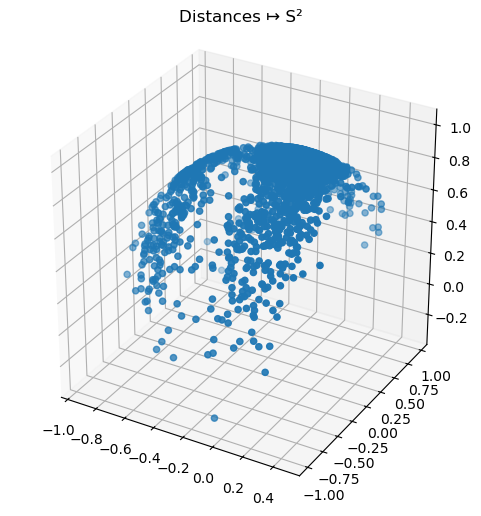

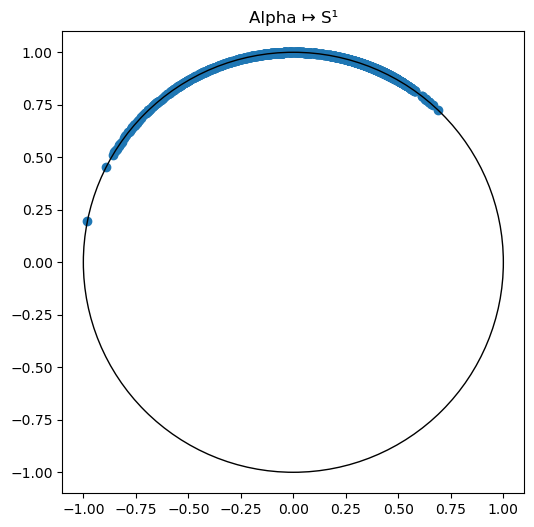

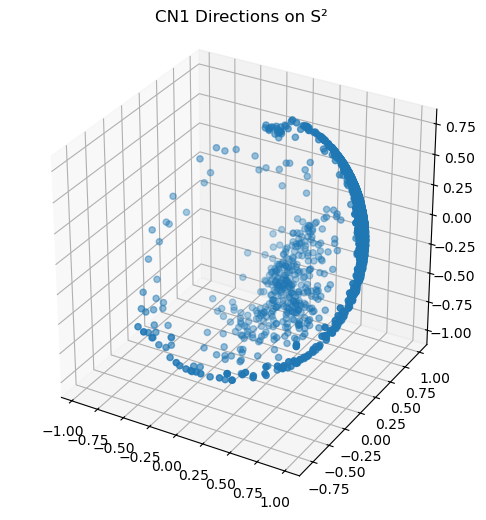

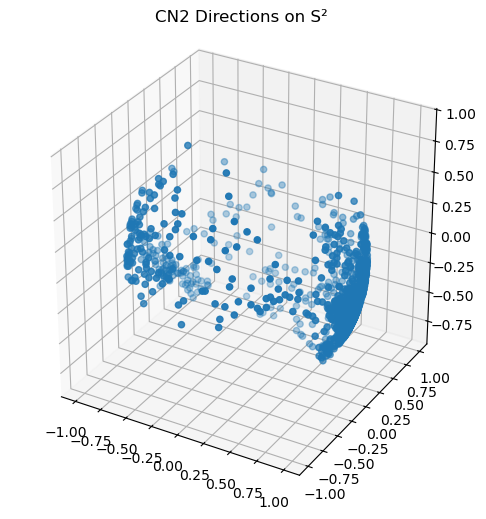

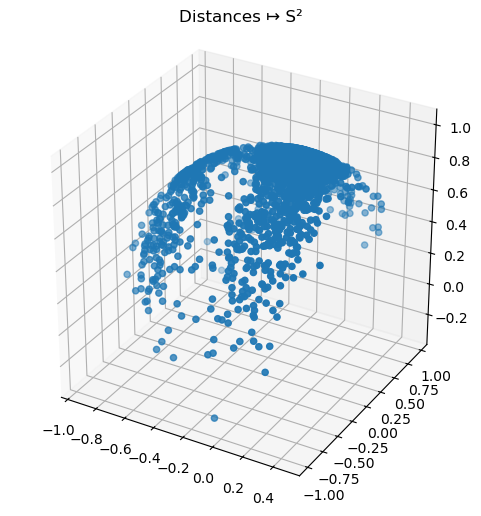

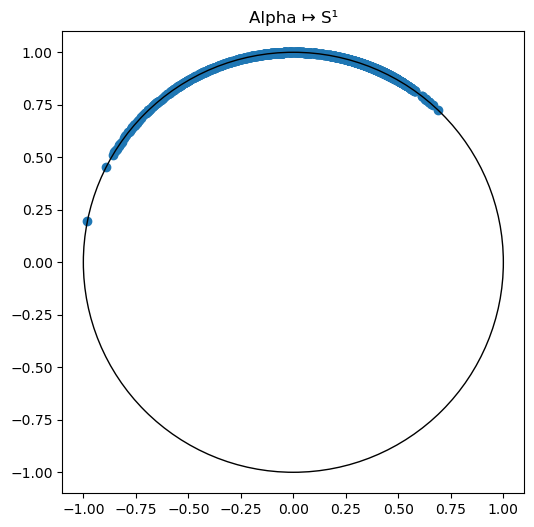

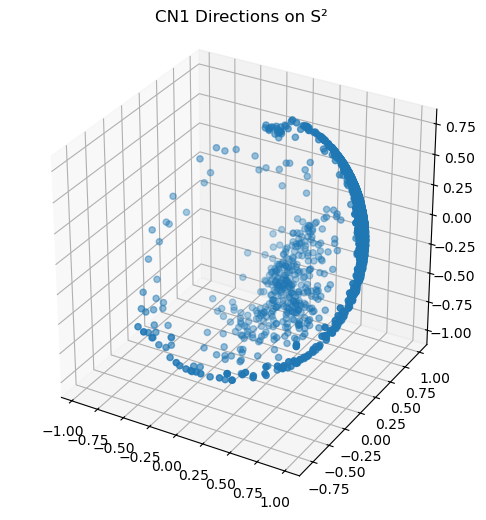

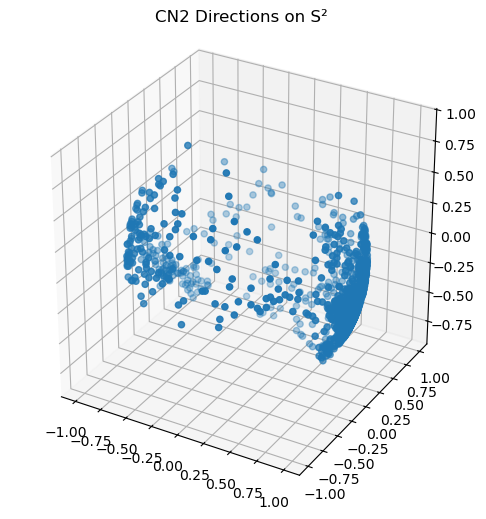

In [ ]:
# -------------------------
# helper from earlier cell
# -------------------------
def spherical_to_vec(theta_deg: np.ndarray, phi_deg: np.ndarray) -> np.ndarray:
    t = np.radians(theta_deg)
    p = np.radians(phi_deg)
    return np.column_stack([
        np.sin(t) * np.cos(p),
        np.sin(t) * np.sin(p),
        np.cos(t)
    ])

# -------------------------
# assume `scaled_coords` is already in your notebook namespace
# scaled_coords ← output of scale_low_res_coords(...)
d2_s, d3_s, alpha_s, theta1, phi1, theta2, phi2 = scaled_coords.T
N = len(d2_s)

# 1) Exponential‐map of (d2,d3) onto S²
mean_dist_s = np.column_stack([d2_s, d3_s]).mean(axis=0)
tangent2d = np.column_stack([d2_s, d3_s]) - mean_dist_s     # (N,2)
V = np.column_stack([tangent2d, np.zeros(N)])               # (N,3)
r = np.linalg.norm(V, axis=1)                               # radii on tangent
dirs = V / r[:, None]                                        # unit tangents
north = np.array([0, 0, 1])
S2_pts = np.cos(r)[:, None] * north + np.sin(r)[:, None] * dirs

# 2) Alpha → S¹
alpha_rad = np.radians(alpha_s)
S1_pts = np.column_stack([np.cos(alpha_rad), np.sin(alpha_rad)])

# 3+4) existing CN atom‐directions on S²
S2_C1 = spherical_to_vec(theta1, phi1)
S2_C2 = spherical_to_vec(theta2, phi2)

# --- Now plot each separately ---

# 1) Distances → S²
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S2_pts[:, 0], S2_pts[:, 1], S2_pts[:, 2])
ax.set_title('Distances ↦ S²')
ax.set_box_aspect([1, 1, 1])
plt.show()

# 2) Alpha ↦ S¹
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(S1_pts[:, 0], S1_pts[:, 1])
circle = Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Alpha ↦ S¹')
plt.show()

# 3) CN1 directions on S²
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S2_C1[:, 0], S2_C1[:, 1], S2_C1[:, 2])
ax.set_title('CN1 Directions on S²')
ax.set_box_aspect([1, 1, 1])
plt.show()

# 4) CN2 directions on S²
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S2_C2[:, 0], S2_C2[:, 1], S2_C2[:, 2])
ax.set_title('CN2 Directions on S²')
ax.set_box_aspect([1, 1, 1])
plt.show()
